<a href="https://colab.research.google.com/github/WendersonLeonardo/Predissaum/blob/main/algoritmo_redes_neurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabalho  - Usando LSTM para prever séries temporais

Nesse laboratório iremos demonstrar como uma LSTM pode ser usada para previsão em séries temporais. Utilizaremos uma rede neuronal LSTM bem simples para tratar um caso de uma série temporal de número de doenças pulmonares na inglaterra

In [1]:
# Importando bibliotecas
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, Softmax
from keras.layers import LSTM, GRU, Conv1D, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
numpy.random.seed(7)

In [ ]:
url2 = 'https://raw.githubusercontent.com/WendersonLeonardo/Predissaum/main/logsDiarios.csv'
dataframe2 = pandas.read_csv(url2, usecols=[1], engine='python', skipfooter=3, sep = ',')
dataframe2.head(3)

,value
0,242
1,287
2,331


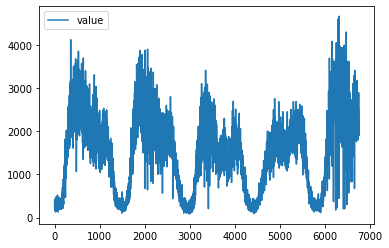

<Figure size 1440x720 with 0 Axes>

In [ ]:
dataframe2.plot()
plt.figure(figsize=(20, 10))
plt.savefig('df2.png')

In [2]:
# Carrega apenas a coluna com o total de doentes por mês 
url = 'Predissaum/logsDiarios2.csv'
#url = 'bi-master-redes-neurais/ldeaths.csv'
url = 'https://raw.githubusercontent.com/WendersonLeonardo/Predissaum/main/logsDiarios.csv'
dataframe = pandas.read_csv(url, usecols=[1], engine='python', skipfooter=3, sep = ',')
dataframe.head(3)

,value
0,242
1,287
2,331


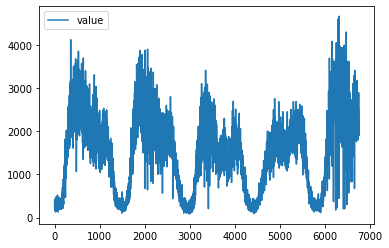

In [3]:
dataframe.plot()
plt.savefig('df.png')

Tratamento dos dados:
*   ajuste da escala dos dados para ficarem entre 0 e 1;
*   divisão dos dados entre treino (67%) e testes (33%)

In [4]:
#Converte a coluna do dataframe pandas em um vetor numpy
dataset = dataframe.values
dataset = dataset.astype('float32')

look_back = 12

# Divite os dados de treino (2/3) e teste (1/3)
# Note que a divisão não é aleatória, mas sim sequencial
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back-1:len(dataset),:]

In [5]:
arq = open('rms3.txt','w')
arq.write('resultados rmse\n')
arq.close()

In [ ]:
#Converte a coluna do dataframe pandas em um vetor numpy
dataset2 = dataframe2.values
dataset2 = dataset2.astype('float32')

look_back2 = 12

Aqui criamos nossos pares de dados $X$ e $Y$, onde $Y_{t} = X_{t-1}$ (para look_bak=1). Uma outra forma de pensar no valor de $Y$ para um dado $X$ é que ele é o próximo $X$ na série temporal.

In [6]:
# Recebe uma série e converte em uma matriz com séries deslocadas.
def create_dataset(dataset, look_back=1, std=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]-dataset[i, 0]
        a /= std
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]-dataset[i + look_back-1, 0])
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
std = train[:, 0].std()
trainX, trainY = create_dataset(train, look_back, std)
testX, testY = create_dataset(test, look_back, std)
#df2X, df2Y = create_dataset(dataset2, look_back, std)
# shape is [samples, time steps, features]

trainX = trainX.reshape(-1, look_back, 1)
testX = testX.reshape(-1, look_back, 1)
#df2X = df2X.reshape(-1, look_back, 1)
trainY = trainY / 30
testY = testY / 30
#df2Y = df2Y / 30

#trainX.shape, testX.shape, df2X.shape

In [7]:
def rodaRedes(nome, rede_camada1, rede_camada2, qtd_camada1, qtd_camada2):
  model1 = Sequential() #gru, 
  model1.add(rede_camada1(qtd_camada1, input_shape=(look_back, 1), return_sequences=True)) # 16, 48
  model1.add(Dropout(0.2))
  #model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=False))
  model1.add(rede_camada2(qtd_camada2, return_sequences=False))
  model1.add(Dense(1))
  model1.compile(loss='mean_squared_error', optimizer='adam') #sgd
  model1.summary()

  callbacks1 = [
      ReduceLROnPlateau(patience=10, factor=0.5, verbose=True),
      ModelCheckpoint(nome, save_best_only=True),
      EarlyStopping(patience=25, verbose=True)
  ]

  history1 = model1.fit(trainX, trainY, epochs=5000, batch_size=24, validation_data=(testX, testY), #epochs
                      verbose=0, callbacks=callbacks1)

  df_history1 = pandas.DataFrame(history1.history)
  ax1 = df_history1[['val_loss', 'loss']].plot(figsize=(10, 5))
  df_history1['lr'].plot(ax=ax1.twinx(), color='gray')
  plt.savefig(nome+'/'+nome+' val_loss '+".png")
  plt.show()

  # Realiza as previsões. Notar que a utilidade de prever trainX é nenhuma. Serve apenas para exibir no gráfico.

  trainPredict1 = model1.predict(trainX)
  testPredict1 = model1.predict(testX)

  plt.scatter(trainY, trainPredict1.ravel(),label='train')
  plt.scatter(testY, testPredict1.ravel(),label='test')
  plt.savefig(nome+'/'+nome+' trainXteste '+".png")
  plt.show()

  #df2Predict = model1.predict(df2X)

  # Calcula os erros de previsão
  arq = open('rms3.txt','a')
  
  trainScore1 = math.sqrt(mean_squared_error(trainY, trainPredict1[:,0]))
  arq.write('Train Score: %.2f RMSE' % (trainScore1))
  testScore1 = math.sqrt(mean_squared_error(testY, testPredict1[:,0]))
  arq.write('Test Score: %.2f RMSE' % (testScore1))
  #df2Score1 = math.sqrt(mean_squared_error(df2Y, df2Predict[:,0]))
  #arq.write('df2 Score: %.2f RMSE' % (df2Score1))
  arq.close()

  # shift train predictions for plotting
  trainPredictPlot1 = (trainPredict1.ravel() * 30) + dataset[look_back:len(trainPredict1)+look_back, 0]

  # shift test predictions for plotting
  testPredictPlot1 = (testPredict1.ravel() * 30) + dataset[len(trainPredict1)+(look_back)-1:len(dataset), 0]

  # shift test predictions for plotting
  #df2PredictPlot1 = (df2Predict.ravel() * 30) + dataset[look_back:len(df2Predict)+look_back, 0]

  # plot baseline and predictions
  plt.figure(figsize=(20, 10))
  plt.plot(dataset)
  plt.plot(look_back+numpy.arange(len(testPredictPlot1))+len(trainPredictPlot1)-1, testPredictPlot1, color='black')
  plt.plot(look_back+numpy.arange(len(trainPredictPlot1)), trainPredictPlot1)
  plt.savefig(nome+'/'+nome+ 'pred' +".png")
  plt.show()

  
  arq = open(nome+'/'+nome+'.csv','w')
  
  arq.close()

  '''# plot baseline and predictions
  plt.figure(figsize=(20, 10))
  plt.plot(dataset2)
  plt.plot(look_back+numpy.arange(len(df2PredictPlot1)), df2PredictPlot1)
  plt.savefig(nome+'/'+nome+ 'pred2' +".png")
  plt.show()'''

In [10]:
def rodaRedes1(nome, rede_camada1, rede_camada2, qtd_camada1, qtd_camada2):
  model1 = Sequential() #gru, 
  model1.add(rede_camada1(qtd_camada1, input_shape=(look_back, 1), return_sequences=True)) # 16, 48
  model1.add(Dropout(0.2))
  #model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=False))
  model1.add(rede_camada2(qtd_camada2, return_sequences=False))
  model1.add(Dense(1))
  model1.compile(loss='mean_squared_error', optimizer='adam') #sgd
  model1.summary()

  callbacks1 = [
      ReduceLROnPlateau(patience=10, factor=0.5, verbose=True),
      ModelCheckpoint(nome, save_best_only=True),
      EarlyStopping(patience=25, verbose=True)
  ]

  history1 = model1.fit(trainX, trainY, epochs=5000, batch_size=24, validation_data=(testX, testY), #epochs
                      verbose=0, callbacks=callbacks1)

  df_history1 = pandas.DataFrame(history1.history)
  ax1 = df_history1[['val_loss', 'loss']].plot(figsize=(10, 5))
  df_history1['lr'].plot(ax=ax1.twinx(), color='gray')
  plt.savefig(nome+'/'+nome+' val_loss '+".png")
  plt.show()

  # Realiza as previsões. Notar que a utilidade de prever trainX é nenhuma. Serve apenas para exibir no gráfico.

  trainPredict1 = model1.predict(trainX)
  testPredict1 = model1.predict(testX)

  plt.scatter(trainY, trainPredict1.ravel(),label='train')
  plt.scatter(testY, testPredict1.ravel(),label='test')
  plt.savefig(nome+'/'+nome+' trainXteste '+".png")
  plt.show()

  #df2Predict = model1.predict(df2X)

  # Calcula os erros de previsão
  '''arq = open('rms3.txt','a')
  
  trainScore1 = math.sqrt(mean_squared_error(trainY, trainPredict1[:,0]))
  arq.write('Train Score: %.2f RMSE' % (trainScore1))
  testScore1 = math.sqrt(mean_squared_error(testY, testPredict1[:,0]))
  arq.write('Test Score: %.2f RMSE' % (testScore1))
  #df2Score1 = math.sqrt(mean_squared_error(df2Y, df2Predict[:,0]))
  #arq.write('df2 Score: %.2f RMSE' % (df2Score1))
  arq.close()'''

  # shift train predictions for plotting
  trainPredictPlot1 = (trainPredict1.ravel() * 30) + dataset[look_back:len(trainPredict1)+look_back, 0]

  # shift test predictions for plotting
  testPredictPlot1 = (testPredict1.ravel() * 30) + dataset[len(trainPredict1)+(look_back)-1:len(dataset), 0]

  # shift test predictions for plotting
  #df2PredictPlot1 = (df2Predict.ravel() * 30) + dataset[look_back:len(df2Predict)+look_back, 0]

  # plot baseline and predictions
  '''plt.figure(figsize=(20, 10))
  plt.plot(dataset)
  plt.plot(look_back+numpy.arange(len(testPredictPlot1))+len(trainPredictPlot1)-1, testPredictPlot1, color='black')
  plt.plot(look_back+numpy.arange(len(trainPredictPlot1)), trainPredictPlot1)
  plt.savefig(nome+'/'+nome+ 'pred' +".png")
  plt.show()'''

  
  arq = open(nome+'/'+nome+'.csv','w')
  
  arq.close()

  return testPredictPlot1

  '''# plot baseline and predictions
  plt.figure(figsize=(20, 10))
  plt.plot(dataset2)
  plt.plot(look_back+numpy.arange(len(df2PredictPlot1)), df2PredictPlot1)
  plt.savefig(nome+'/'+nome+ 'pred2' +".png")
  plt.show()'''

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 56)            12992     
                                                                 
 dropout_1 (Dropout)         (None, 12, 56)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                11392     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 24,417
Trainable params: 24,417
Non-trainable params: 0
_________________________________________________________________



Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 64: early stopping


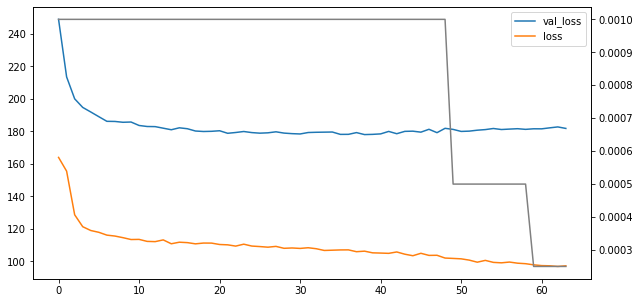

70/70 [==============================] - 0s 4ms/step


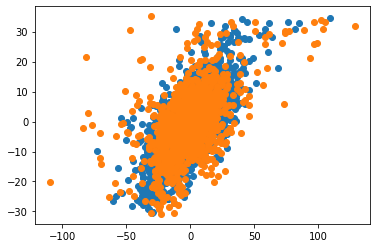

In [11]:
predict1 = rodaRedes1('qwert', LSTM, LSTM, 56, 32)

In [14]:
# um dicionario para armazenar todos os valores preditos de cada combinação
dicDados = {}

In [20]:
len(predict1.tolist()+[10,2])

2231

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 56)            12992     
                                                                 
 dropout (Dropout)           (None, 12, 56)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                11392     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 24,417
Trainable params: 24,417
Non-trainable params: 0
_________________________________________________________________



Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 62: early stopping


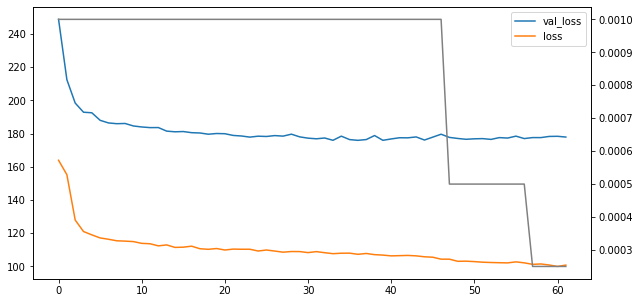

70/70 [==============================] - 0s 4ms/step


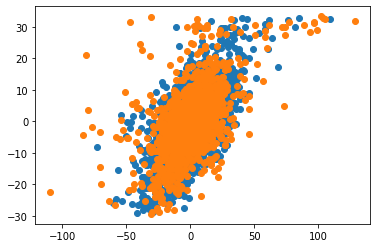

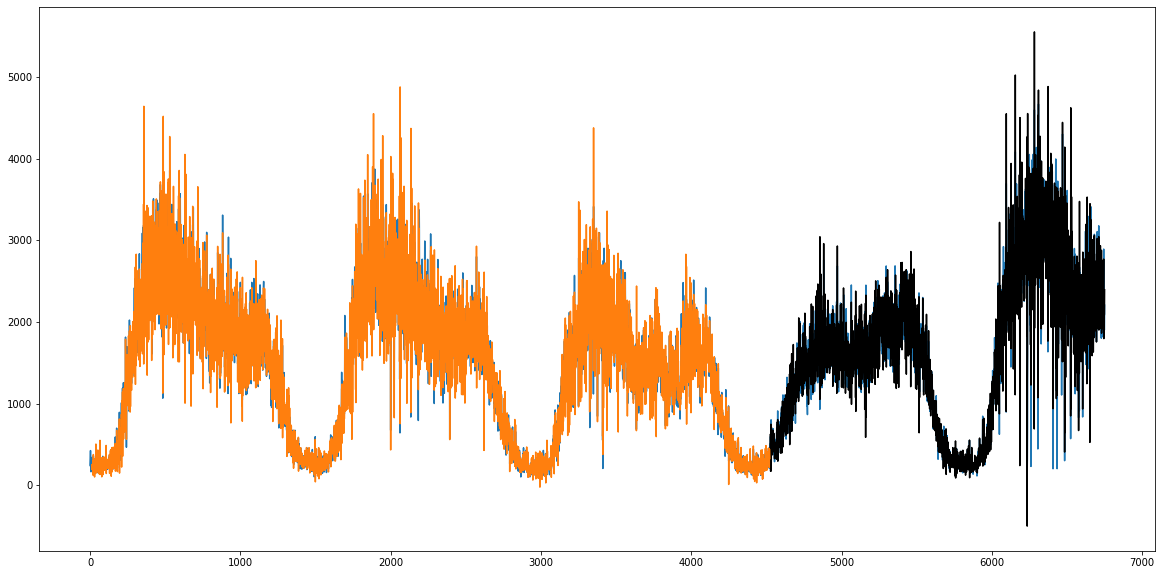

In [8]:
rodaRedes('qwert', LSTM, LSTM, 56, 32)

In [ ]:
camadaLSTM = LSTM
camadaGRU = GRU

qtd1T1 = 56
qtd2T1 = 32

qtd1T2 = 81
qtd2T2 = 27

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 56)            12992     
                                                                 
 dropout (Dropout)           (None, 12, 56)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                11392     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 24,417
Trainable params: 24,417
Non-trainable params: 0
_________________________________________________________________



Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 63: early stopping


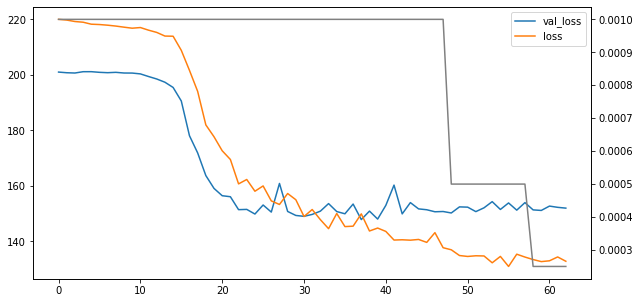

11/11 [==============================] - 0s 6ms/step


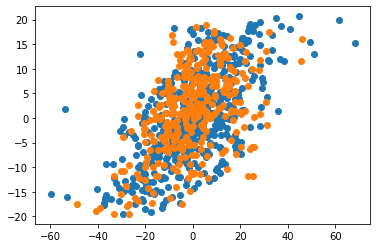

Train Score: 11.36 RMSE
Test Score: 12.33 RMSE


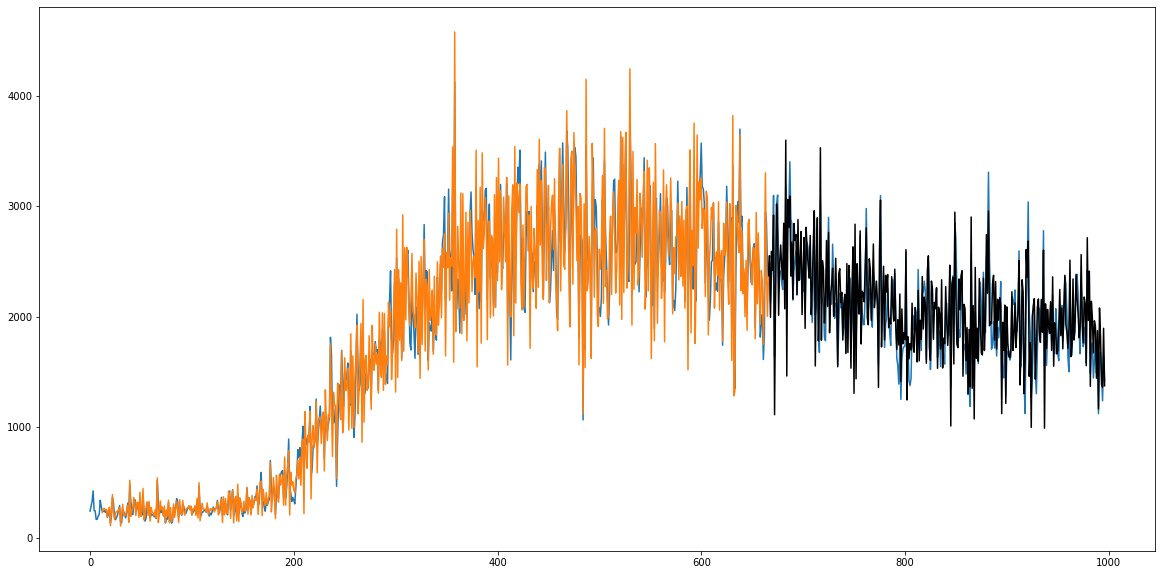

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 56)            9912      
                                                                 
 dropout_1 (Dropout)         (None, 12, 56)            0         
                                                                 
 gru_1 (GRU)                 (None, 32)                8640      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 18,585
Trainable params: 18,585
Non-trainable params: 0
_________________________________________________________________



Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 50: early stopping


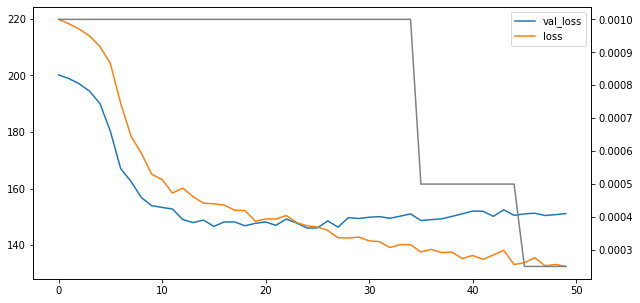

11/11 [==============================] - 0s 5ms/step


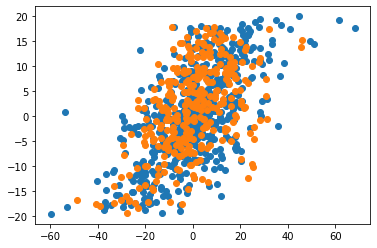

Train Score: 11.44 RMSE
Test Score: 12.29 RMSE


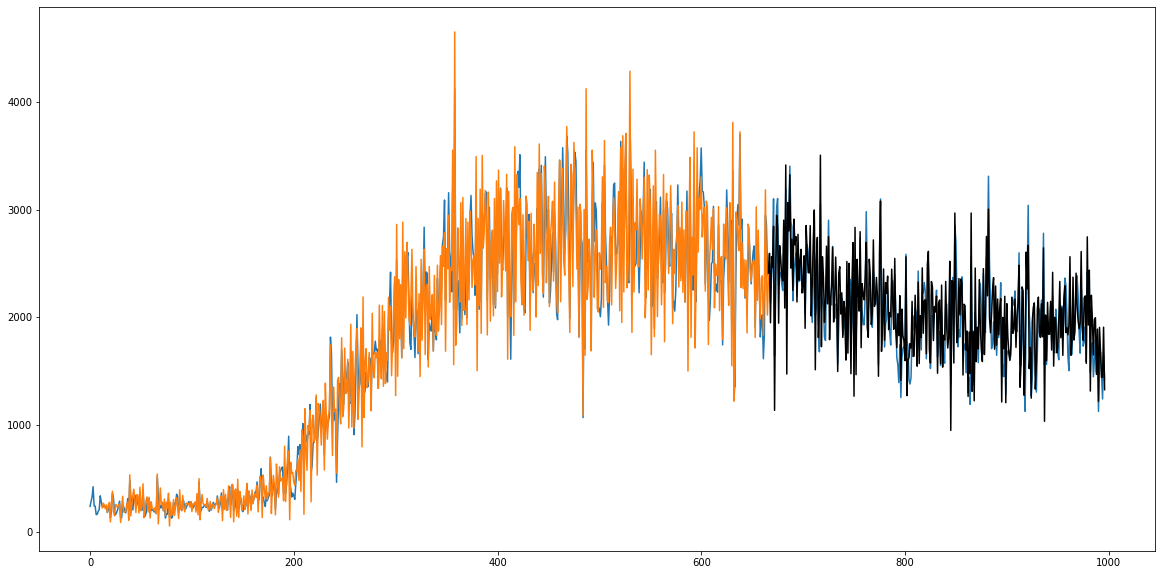

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 81)            26892     
                                                                 
 dropout_2 (Dropout)         (None, 12, 81)            0         
                                                                 
 lstm_3 (LSTM)               (None, 27)                11772     
                                                                 
 dense_2 (Dense)             (None, 1)                 28        
                                                                 
Total params: 38,692
Trainable params: 38,692
Non-trainable params: 0
_________________________________________________________________



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 56: early stopping


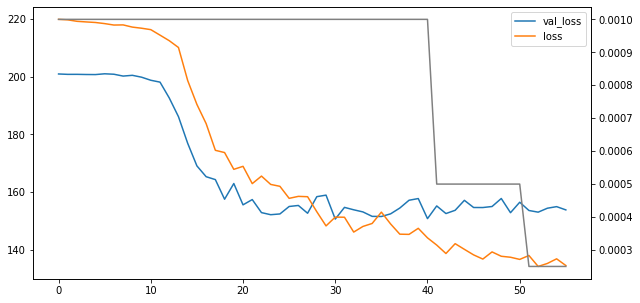

11/11 [==============================] - 0s 8ms/step


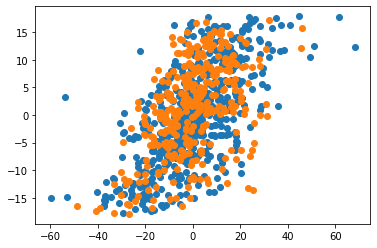

Train Score: 11.52 RMSE
Test Score: 12.40 RMSE


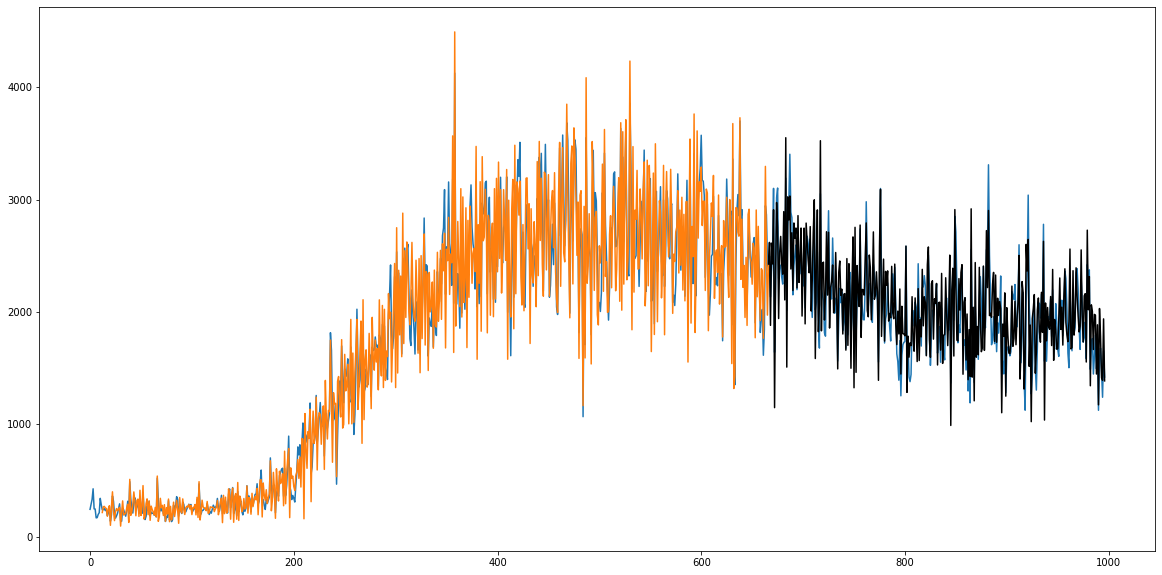

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 12, 81)            20412     
                                                                 
 dropout_3 (Dropout)         (None, 12, 81)            0         
                                                                 
 gru_3 (GRU)                 (None, 27)                8910      
                                                                 
 dense_3 (Dense)             (None, 1)                 28        
                                                                 
Total params: 29,350
Trainable params: 29,350
Non-trainable params: 0
_________________________________________________________________



Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 48: early stopping


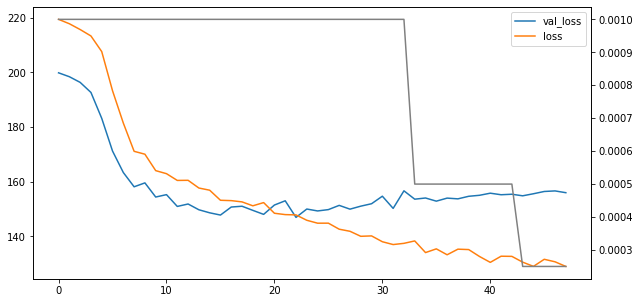

11/11 [==============================] - 0s 6ms/step


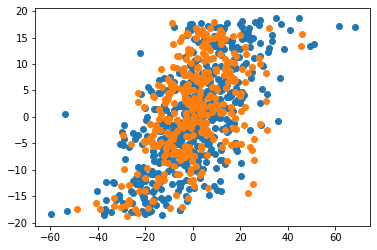

Train Score: 11.30 RMSE
Test Score: 12.49 RMSE


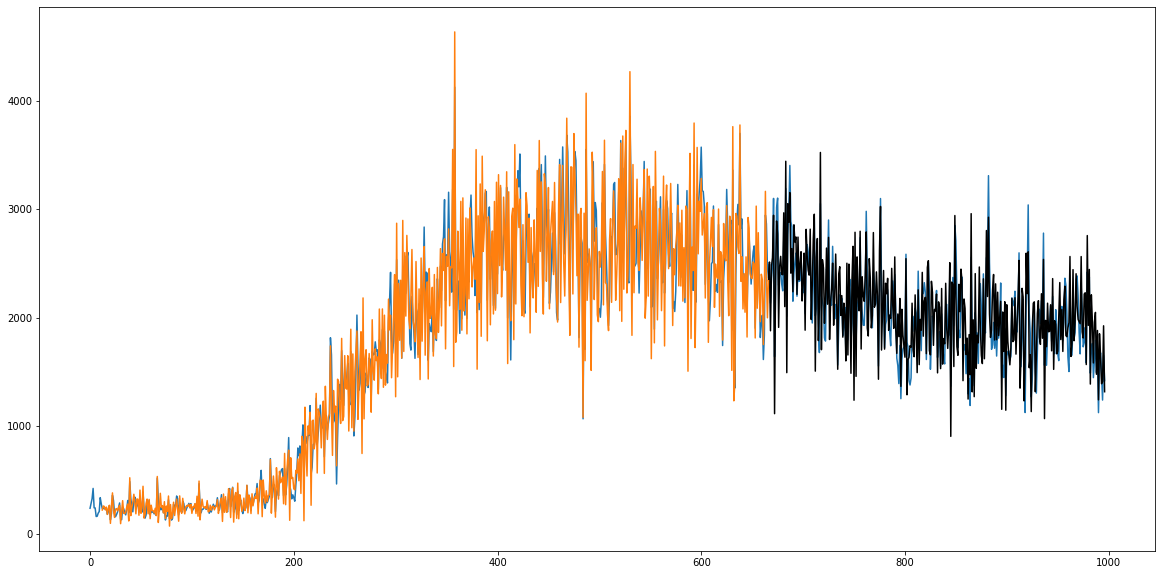

In [ ]:
#TESTE 1: 2 camadas = 56,32 
teste1LSTM = 'teste1 full LSTM'
rodaRedes(teste1LSTM,camadaLSTM,camadaLSTM,qtd1T1,qtd2T1)

teste1GRU = 'teste1 full GRU'
rodaRedes(teste1GRU,camadaGRU,camadaGRU,qtd1T1,qtd2T1)

#TESTE 2 2 camadas = 81,27
teste2LSTM = 'teste2 full LSTM'
rodaRedes(teste2LSTM,camadaLSTM,camadaLSTM,qtd1T2,qtd2T2)

teste2GRU = 'teste2 full GRU'
rodaRedes(teste2GRU,camadaGRU,camadaGRU,qtd1T2,qtd2T2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 56)            12992     
                                                                 
 dropout_4 (Dropout)         (None, 12, 56)            0         
                                                                 
 gru_4 (GRU)                 (None, 32)                8640      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,665
Trainable params: 21,665
Non-trainable params: 0
_________________________________________________________________



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 43: early stopping


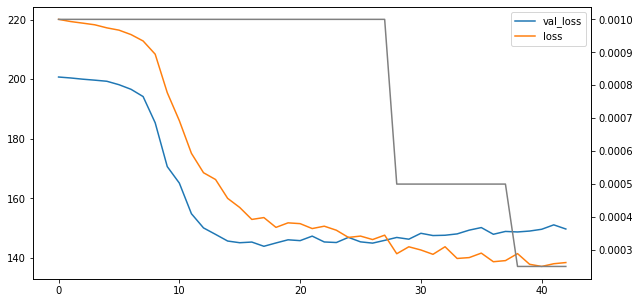

11/11 [==============================] - 0s 6ms/step


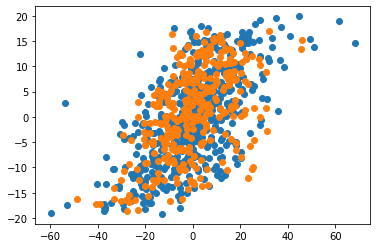

Train Score: 11.63 RMSE
Test Score: 12.24 RMSE


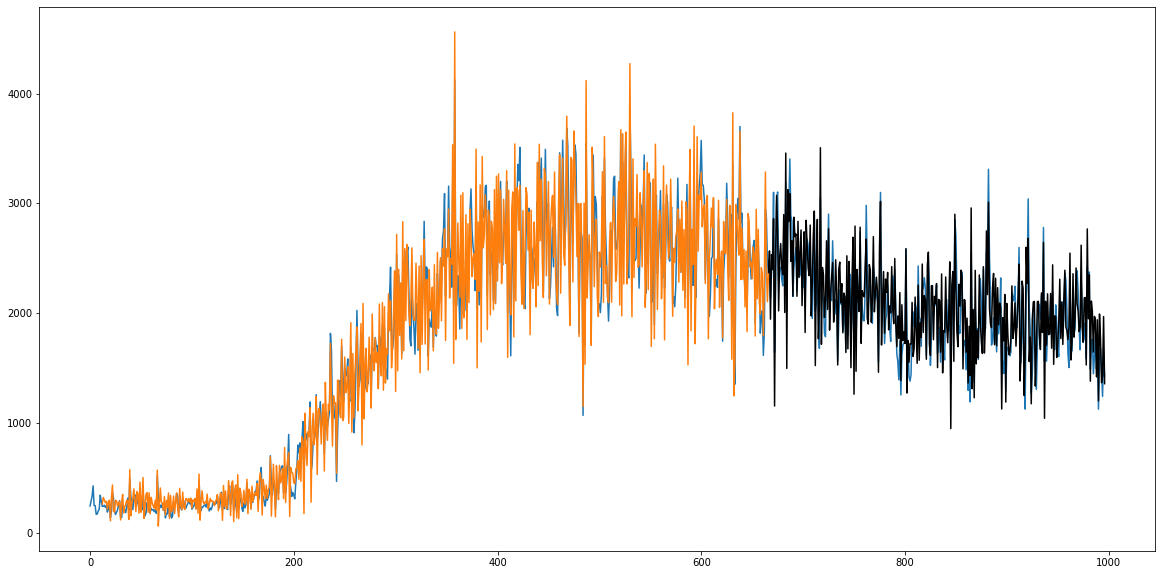

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 12, 56)            9912      
                                                                 
 dropout_5 (Dropout)         (None, 12, 56)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                11392     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,337
Trainable params: 21,337
Non-trainable params: 0
_________________________________________________________________



Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 59: early stopping


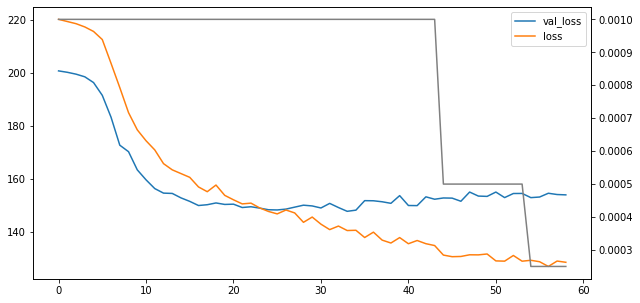

11/11 [==============================] - 0s 6ms/step


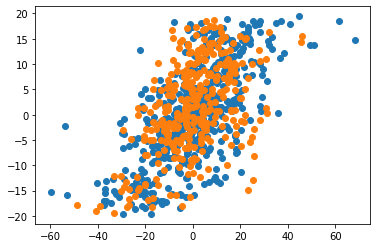

Train Score: 11.18 RMSE
Test Score: 12.41 RMSE


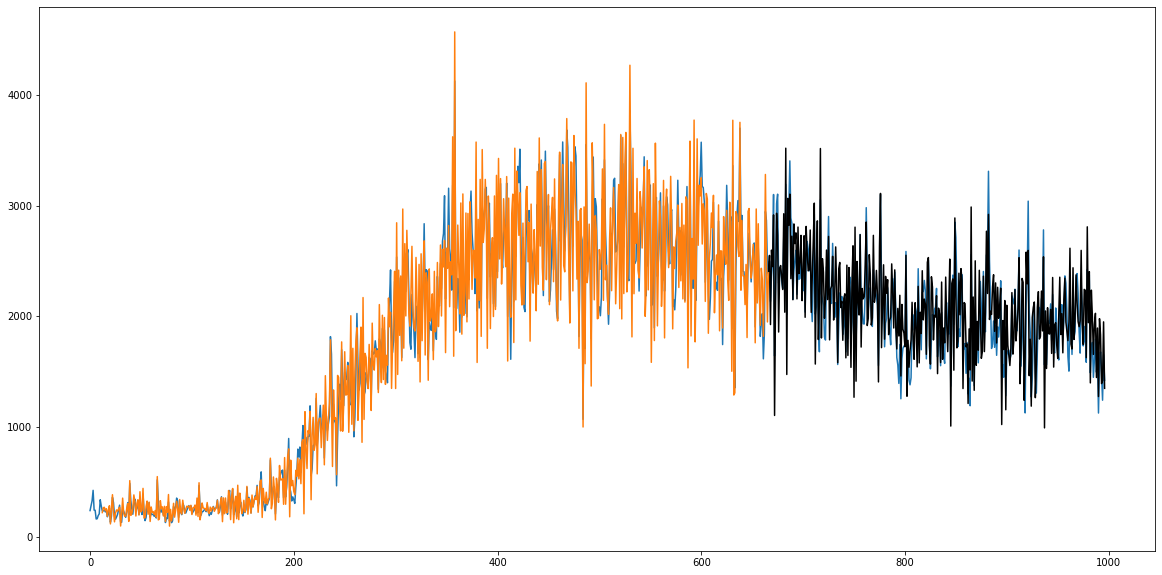

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 56)            12992     
                                                                 
 dropout_6 (Dropout)         (None, 12, 56)            0         
                                                                 
 gru_6 (GRU)                 (None, 32)                8640      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,665
Trainable params: 21,665
Non-trainable params: 0
_________________________________________________________________



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 47: early stopping


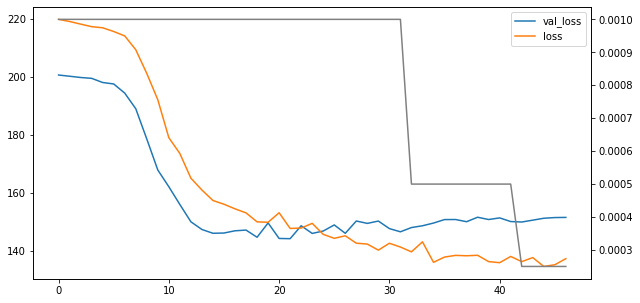

11/11 [==============================] - 0s 6ms/step


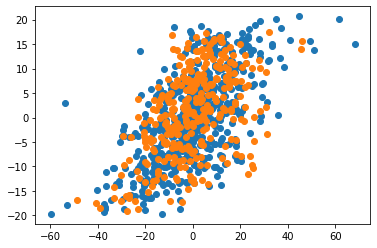

Train Score: 11.52 RMSE
Test Score: 12.31 RMSE


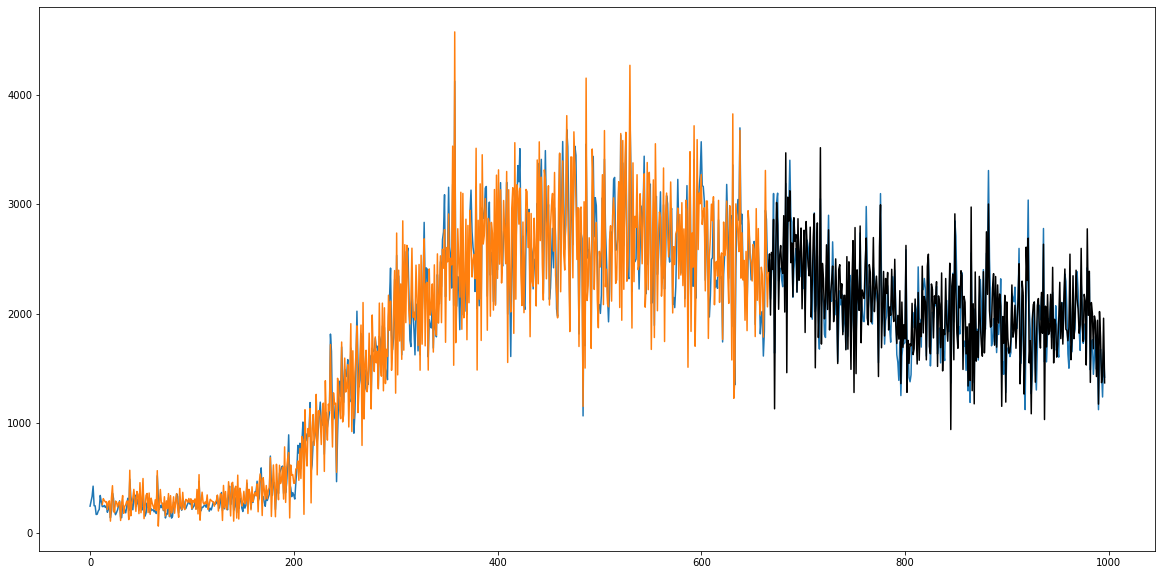

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 12, 56)            9912      
                                                                 
 dropout_7 (Dropout)         (None, 12, 56)            0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                11392     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,337
Trainable params: 21,337
Non-trainable params: 0
_________________________________________________________________



Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 59: early stopping


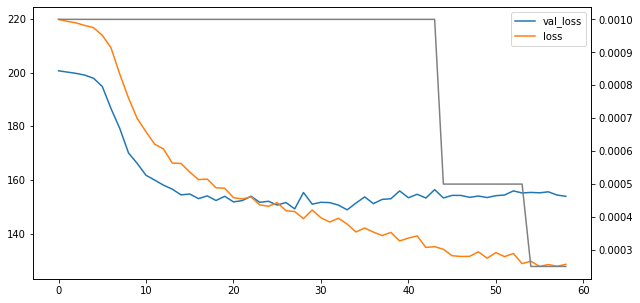

11/11 [==============================] - 0s 6ms/step


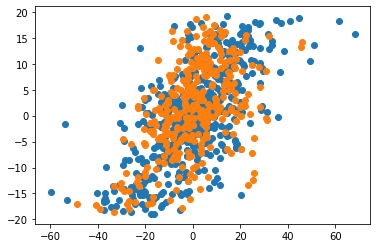

Train Score: 11.21 RMSE
Test Score: 12.41 RMSE


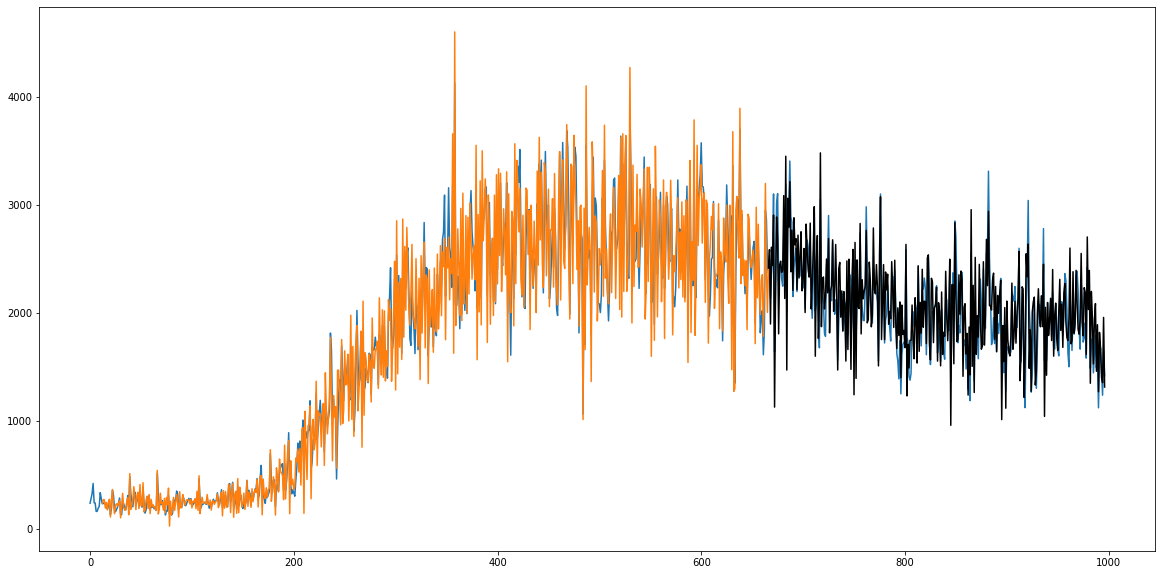

In [ ]:
#TESTE 1 mix: 2 camadas = 56,32 
teste1LSTMGRU = 'teste1LSTMGRU'
rodaRedes(teste1LSTMGRU,camadaLSTM,camadaGRU,qtd1T1,qtd2T1)

teste1GRULSTM = 'teste1GRULSTM'
rodaRedes(teste1GRULSTM,camadaGRU,camadaLSTM,qtd1T1,qtd2T1)

#TESTE 2  mix: 2 camadas = 81,27
teste2LSTMGRU = 'teste2LSTMGRU'
rodaRedes(teste2LSTMGRU,camadaLSTM,camadaGRU,qtd1T1,qtd2T1)

teste2GRULSTM = 'teste2GRULSTM'
rodaRedes(teste2GRULSTM,camadaGRU,camadaLSTM,qtd1T1,qtd2T1)

Ao final das previsões, reescalonamos os dados para a escala original e calculamos as métricas de RMSE.

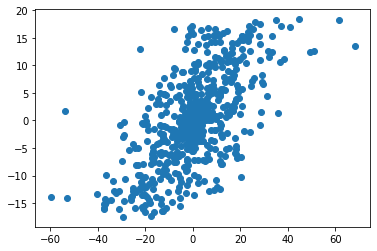

In [ ]:
plt.scatter(trainY, trainPredict1.ravel())

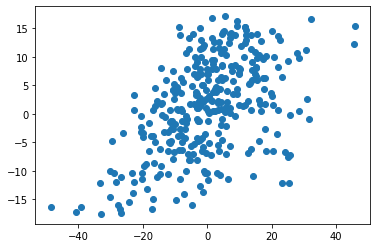

In [ ]:
plt.scatter(testY, testPredict1.ravel())
a = 'LSTM LSTM'
plt.savefig(a+'/teste1.png')

In [ ]:
# Calcula os erros de previsão
trainScore1 = math.sqrt(mean_squared_error(trainY, trainPredict1[:,0]))
print('Train Score: %.2f RMSE' % (trainScore1))
testScore1 = math.sqrt(mean_squared_error(testY, testPredict1[:,0]))
print('Test Score: %.2f RMSE' % (testScore1))

Train Score: 11.50 RMSE
Test Score: 12.34 RMSE


Imprime o gráfico da previsão 

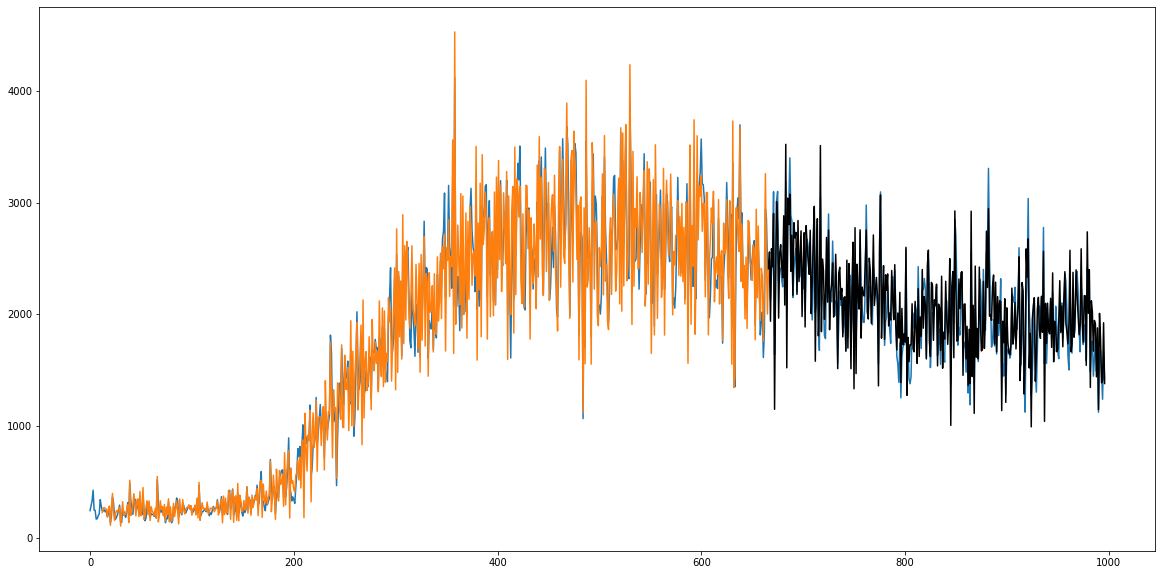

In [ ]:
# shift train predictions for plotting
trainPredictPlot1 = (trainPredict1.ravel() * 30) + dataset[look_back:len(trainPredict1)+look_back, 0]

# shift test predictions for plotting
testPredictPlot1 = (testPredict1.ravel() * 30) + dataset[len(trainPredict1)+(look_back)-1:len(dataset), 0]

# plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(dataset)
plt.plot(look_back+numpy.arange(len(testPredictPlot1))+len(trainPredictPlot1)-1, testPredictPlot1, color='black')
plt.plot(look_back+numpy.arange(len(trainPredictPlot1)), trainPredictPlot1)
plt.show()

### Agora tente você melhorar o resultado do indicador RMSE